# AVCMI 20180207

In [30]:
# Import libraries

import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LinearRegression

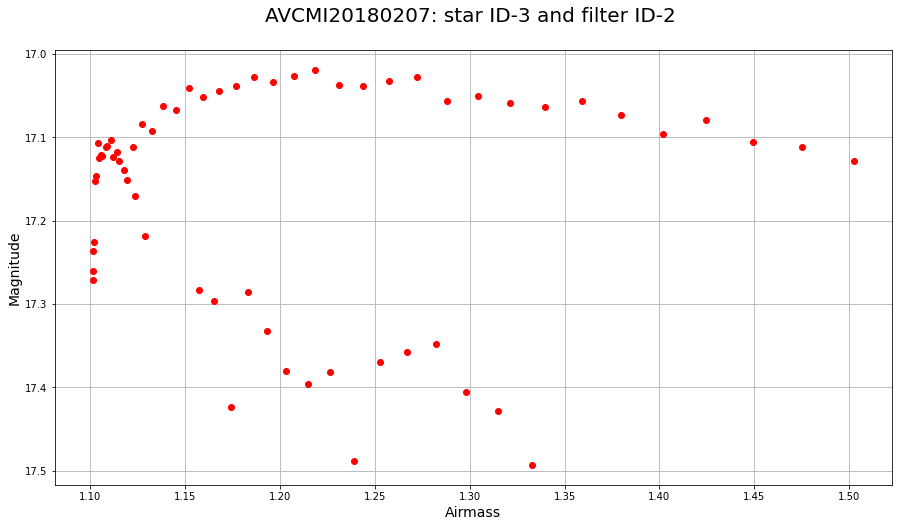

In [89]:
# Import data

data = pd.read_csv('avcmi20180207', sep = '  ', header=None, engine='python')
data.columns = ['name','ID','airmass','filt','JD','mag_obs','mag_err']


ID_1 = np.array(data['ID'])
airmass_1 = np.array(data['airmass'])
filt_1 = np.array(data['filt'])
mag_obs_1 = np.array(data['mag_obs'])

plt.figure(figsize=(15,8))
plt.plot(airmass_1[(np.array(filt_1)==2) & (ID_1==3)], mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)], 'ro')
plt.title('AVCMI20180207: star ID-3 and filter ID-2 \n',fontsize=20)
plt.xlabel('Airmass',fontsize=14)
plt.ylabel('Magnitude',fontsize=14)
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('AVCMI20180207.png')
plt.show()

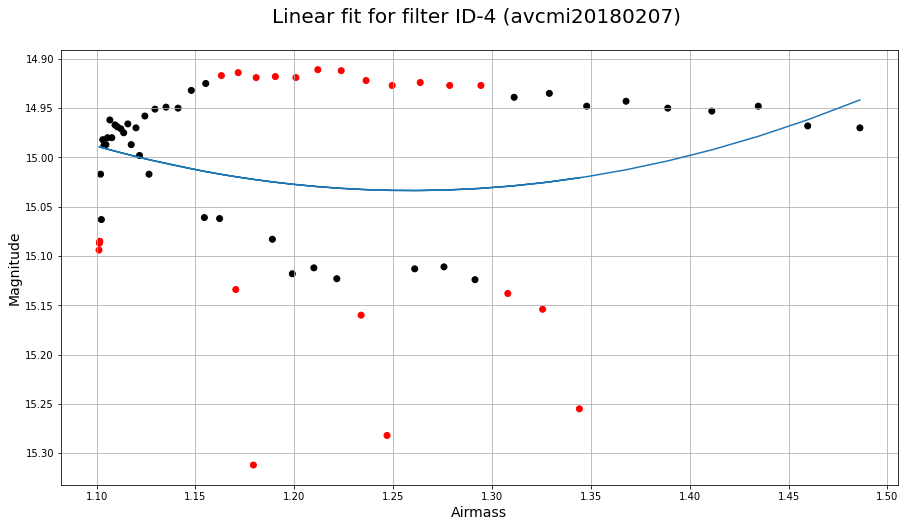

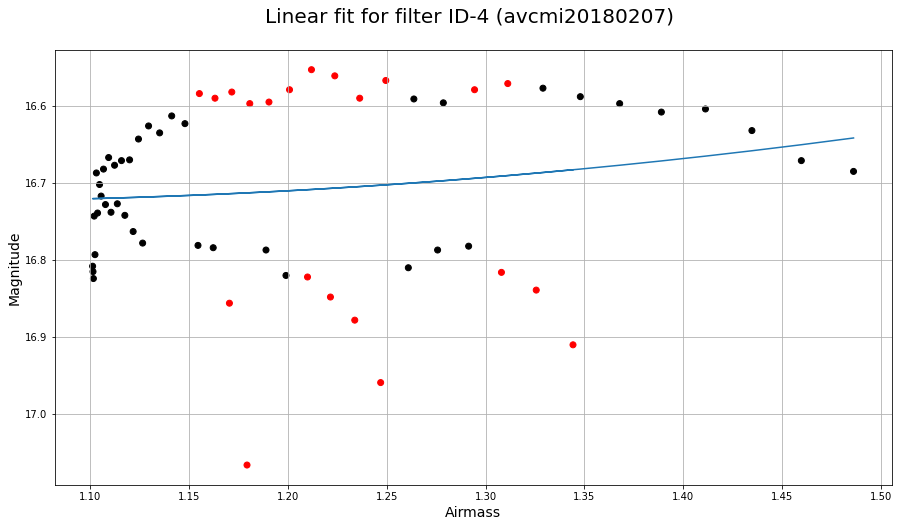

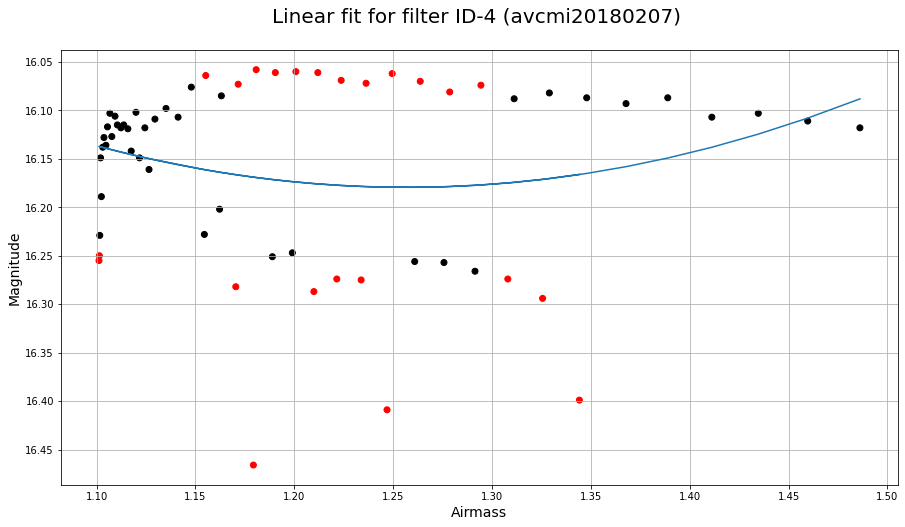

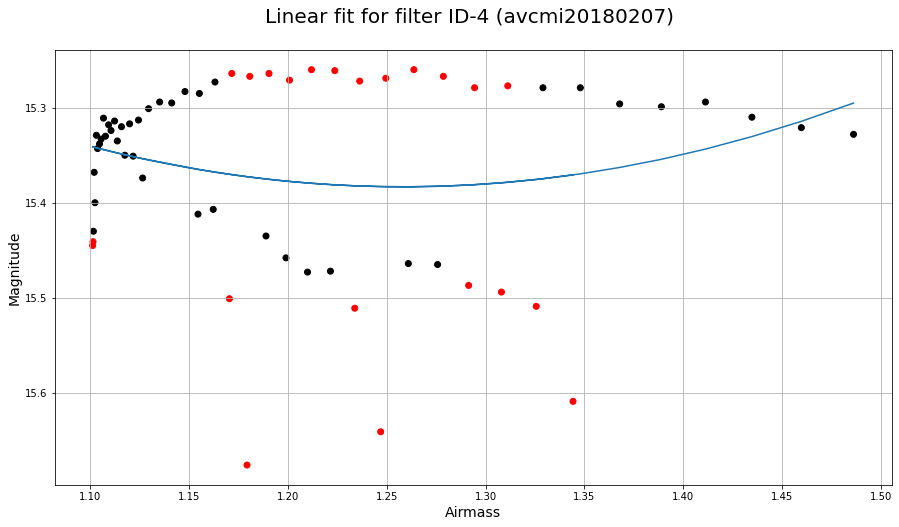

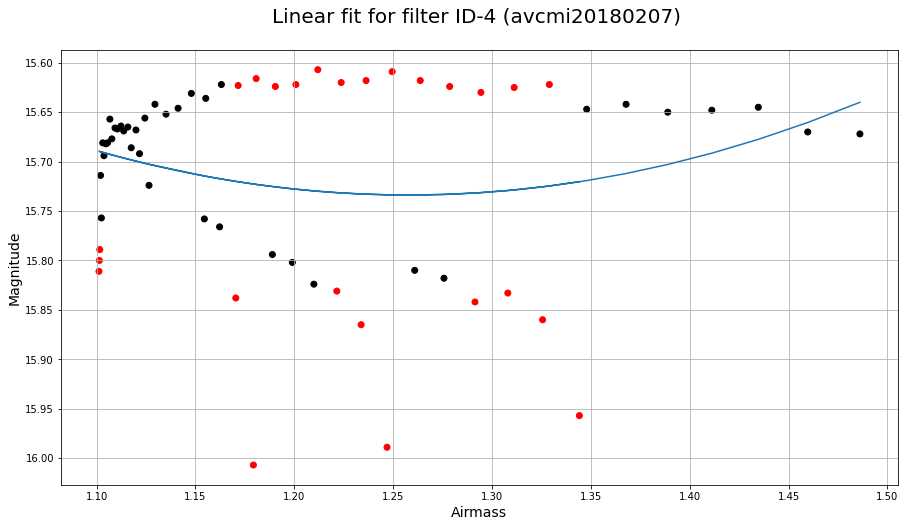

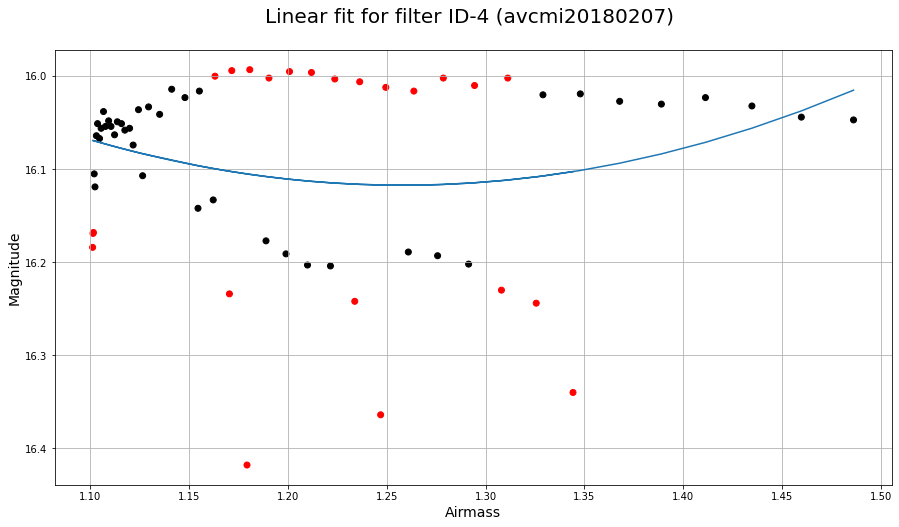

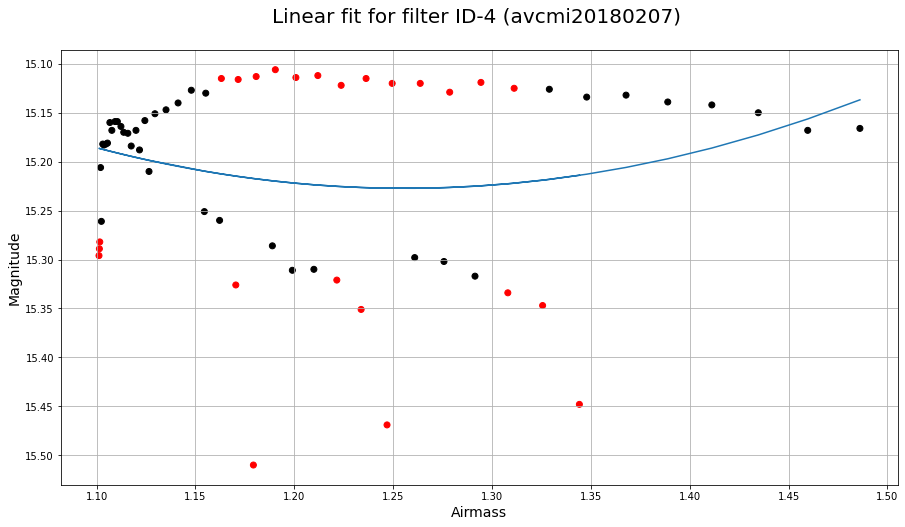

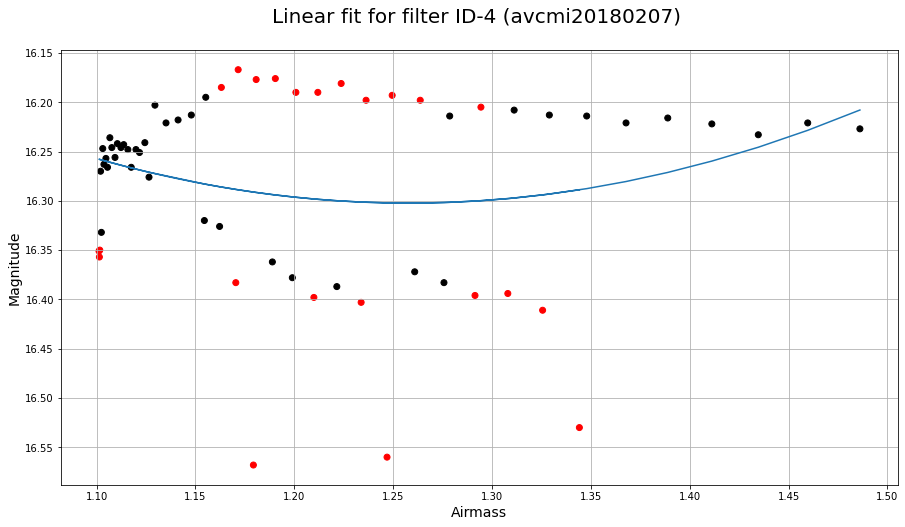

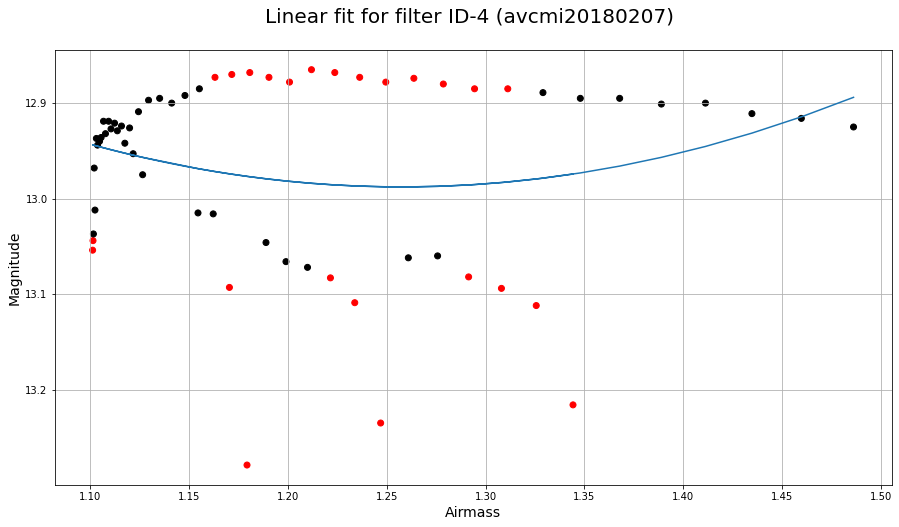

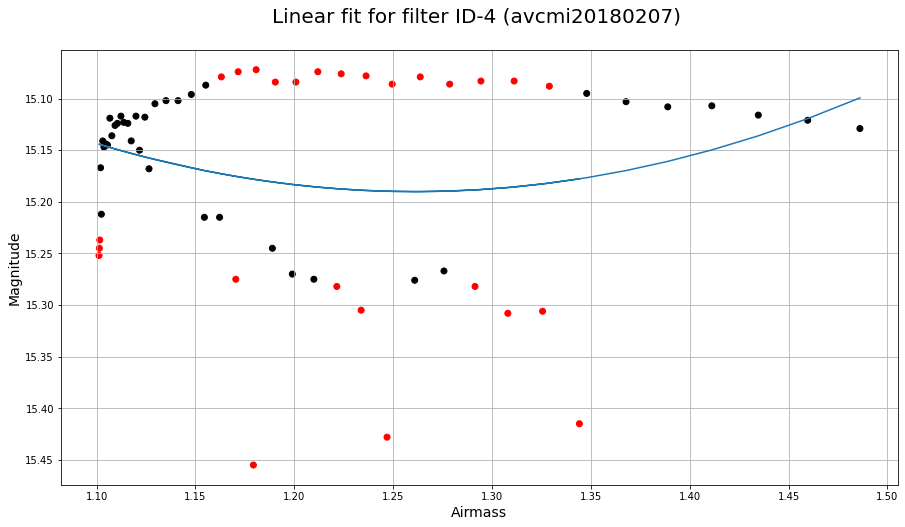

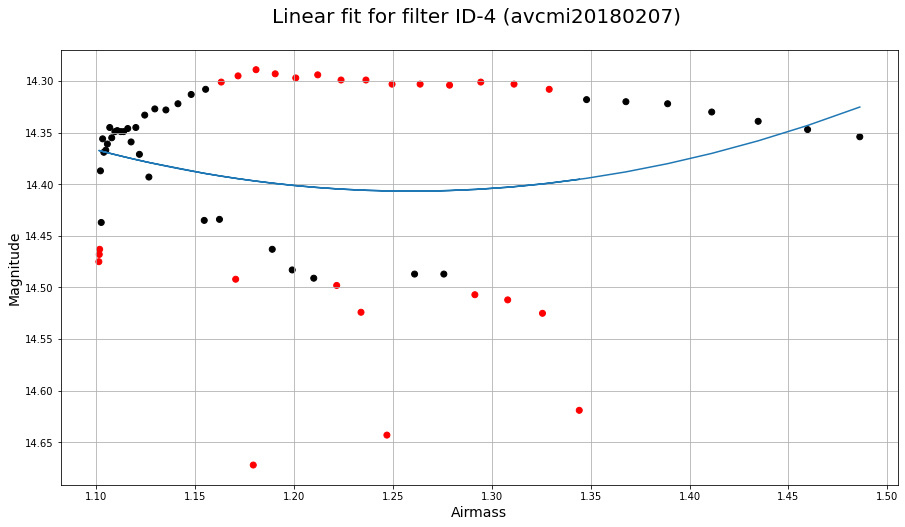

In [82]:
for i in list(np.arange(1,12,1)):
    X = np.array(airmass_1[(filt_1==4) & (ID_1==i)])
    Y = np.array(mag_obs_1[(filt_1==4) & (ID_1==i)])

    poly_degree = 2
    sd_cutoff = 1

    coeffs = np.polyfit(X, Y, poly_degree)
    poly_eqn = np.poly1d(coeffs)

    Y_hat = poly_eqn(X)
    delta = Y - Y_hat
    sd_p = np.std(delta)

    ok = abs(delta) < sd_p * sd_cutoff

    plt.figure(figsize=(15,8))
    
    plt.scatter(X, Y, color=np.where(ok, 'k', 'r'))
    plt.plot(X, Y_hat)
    plt.gca().invert_yaxis()
    plt.title('Linear fit for filter ID-4 (avcmi20180207) \n',fontsize=20)
    plt.xlabel('Airmass',fontsize=14)
    plt.ylabel('Magnitude',fontsize=14)
    plt.grid()
    plt.show()

In [ ]:
# Huber loss

from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

ID_1 = np.array(data['ID'])
airmass_1 = np.array(data['airmass'])
filt_1 = np.array(data['filt'])
mag_obs_1 = np.array(data['mag_obs'])

y = mag_obs_1[(filt_1==2) & (ID_1==3)]
x = airmass_1[(filt_1==2) & (ID_1==3)]

# standardize    
x_scaler, y_scaler = StandardScaler(), StandardScaler()
x_train = x_scaler.fit_transform(x[..., None])
y_train = y_scaler.fit_transform(y[..., None])

# fit model
model = HuberRegressor(epsilon=1)
model.fit(x_train, y_train.ravel())

# do some predictions
test_x = airmass_1[(filt_1==2) & (ID_1==3)]
predictions = y_scaler.inverse_transform(
    model.predict(x_scaler.transform(test_x[..., None]))
)

Maximum likelihood method:
m:  0.0183570417778701
b:  17.14486711489645


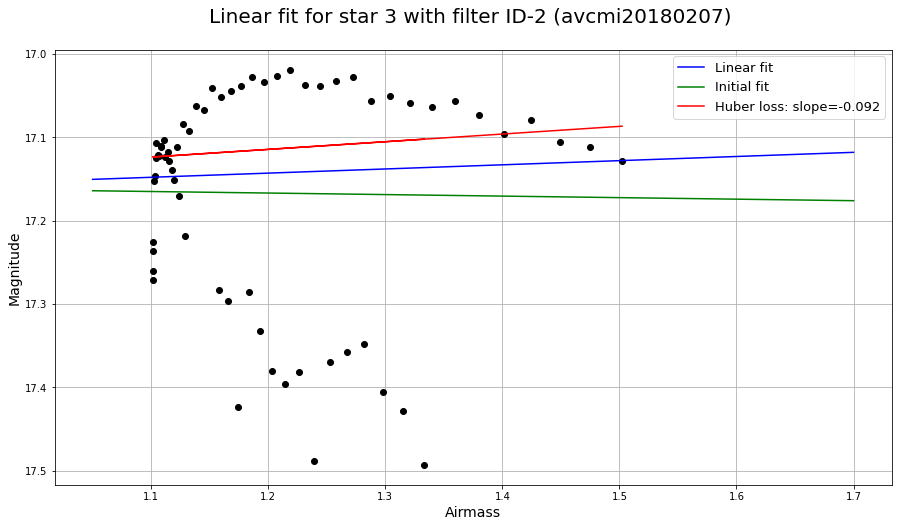

In [88]:
ID_1 = np.array(data['ID'])
airmass_1 = np.array(data['airmass'])
filt_1 = data['filt']
mag_obs_1 = np.array(data['mag_obs'])
mag_err_1 = np.array(data['mag_err'])

A = np.vander(airmass_1[(np.array(filt_1)==2) & (ID_1==3)], 2)
C = np.diag(mag_err_1[(np.array(filt_1)==2) & (ID_1==3)] * mag_err_1[(np.array(filt_1)==2) & (ID_1==3)])
ATA = np.dot(A.T, A/(mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)] / mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]**2))


# Fit curve with likelihood method

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma_square = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model)**2 / sigma_square + np.log(sigma_square))

np.random.seed(42)
nil = lambda *args: -log_likelihood(*args)
initial = np.array([0.2, 20, np.log(0.02)])
soln = minimize(nil, initial, args=(airmass_1[(np.array(filt_1)==2) & (ID_1==3)],
                                    mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)], 
                                    mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]))
mag_max_lik, b_max_lik, log_f_max_lik = soln.x
print("Maximum likelihood method:")
print("m: ", mag_max_lik)
print("b: ", b_max_lik)


plt.figure(figsize=(15,8))
plt.plot(airmass_1[(np.array(filt_1)==2) & (ID_1==3)], mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)], 'ko')
plt.gca().invert_yaxis()
xx = np.linspace(1.05, 1.7, 100)
yy = xx * w[0] + w[1]
yy2 = xx * mag_max_lik + b_max_lik

plt.plot(xx, yy, '-', color='b',label='Linear fit')
plt.plot(xx, yy2, '-', color='g',label='Initial fit')
plt.plot(test_x, predictions, 'r', label='Huber loss: slope='+
         str(round(np.polyfit(test_x, predictions,1)[0],4)))

plt.legend(fontsize=13)
plt.title('Linear fit for star 3 with filter ID-2 (avcmi20180207) \n',fontsize=20)
plt.xlabel('Airmass',fontsize=14)
plt.ylabel('Magnitude',fontsize=14)
plt.grid()

plt.savefig('Huber_loss.png')
plt.show()

In [100]:
for i in range(2,6,1):
    y = mag_obs_1[(filt_1==i) & (ID_1==11)]
    x = airmass_1[(filt_1==i) & (ID_1==11)]

    x_scaler, y_scaler = StandardScaler(), StandardScaler()
    x_train = x_scaler.fit_transform(x[..., None])
    y_train = y_scaler.fit_transform(y[..., None])

    model = HuberRegressor(epsilon=1)
    model.fit(x_train, y_train.ravel())

    test_x = airmass_1[(filt_1==i) & (ID_1==11)]
    predictions = y_scaler.inverse_transform(
        model.predict(x_scaler.transform(test_x[..., None]))
    )
        
    print(round(np.polyfit(test_x, predictions,1)[0],4))

-0.1139
-0.1021
-0.0703
-0.0654
